# Carbon in the ocean: practical

## Set-up and intro to xarray

### Import data

This first cell imports the data you will use.  You need to run it and understand at least roughly what is going on, but nothing here needs to be changed.

<IPython.core.display.Javascript object>


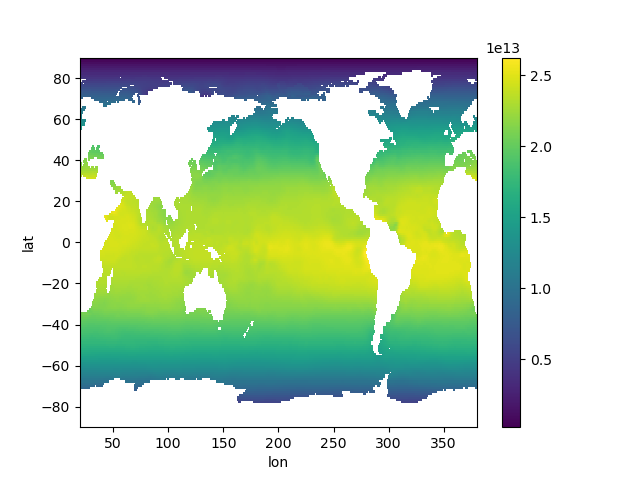

In [28]:
# Import packages
import PyCO2SYS as pyco2, numpy as np, xarray as xr
%matplotlib notebook
from matplotlib import pyplot as plt
from area import area
from vufuncs import seawater_1atm_MP81

# Import GLODAP gridded & mapped data
glodap = xr.Dataset()
glodap['alkalinity'] = xr.open_dataarray('data/GLODAPv2.2016b.TAlk_only.nc')
glodap['dic'] = xr.open_dataarray('data/GLODAPv2.2016b.TCO2_only.nc')
glodap['nitrate'] = xr.open_dataarray('data/GLODAPv2.2016b.NO3_only.nc')
glodap['salinity'] = xr.open_dataarray('data/GLODAPv2.2016b.salinity_only.nc')
glodap['temperature'] = xr.open_dataarray('data/GLODAPv2.2016b.temperature_only.nc')

# Pick out surface and bottom data
surface = glodap.bfill(dim='depth_surface').isel(depth_surface=0)
bottom = glodap.ffill(dim='depth_surface').isel(depth_surface=-1)

# Import climatological mean mixed layer depth and interpolate it to match the GLODAP grid
surface['mld'] = xr.open_dataarray('data/mld_mean.nc').interp_like(surface)

# Calculate surface seawater density in g/cm³
surface['density'] = seawater_1atm_MP81(temperature=surface.temperature, salinity=surface.salinity)

# Calculate surface area of each grid cell in m²
surface_area = np.full_like(surface.lat, np.nan)
for i, lat_i in enumerate(surface.lat):
    surface_area[i] = area({
        'type': 'Polygon',
        'coordinates': [[[0, lat_i + 0.5], [1, lat_i + 0.5], [1, lat_i - 0.5], [0, lat_i - 0.5]]],
    })
surface['area'] = ('lat', surface_area)

### Basic maps

You can make maps of the variables in `surface` or `bottom` (any of `alkalinity`, `dic`, `nitrate`, `salinity`, `temperature`, `mld`, `density` and `area`) as follows:

<IPython.core.display.Javascript object>


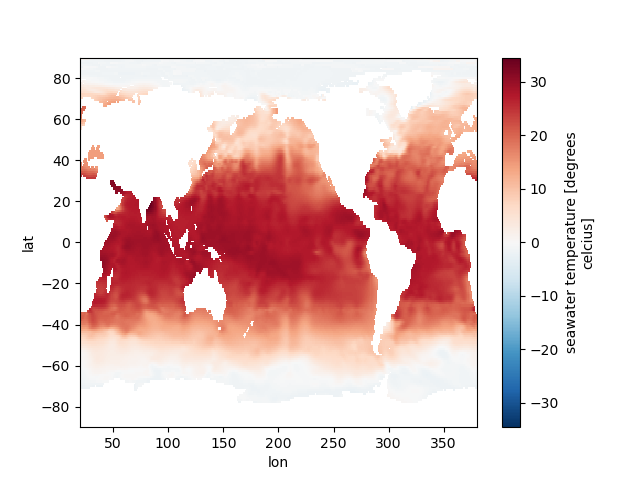

In [31]:
plt.figure()
surface.temperature.plot()

### Maps of calculations

You can also do calculations with these variables and map the results directly:

In [ ]:
plt.figure()
(bottom.alkalinity - surface.alkalinity).plot()

### Scatter plots

To make a scatter plot between any of the variables:

<IPython.core.display.Javascript object>


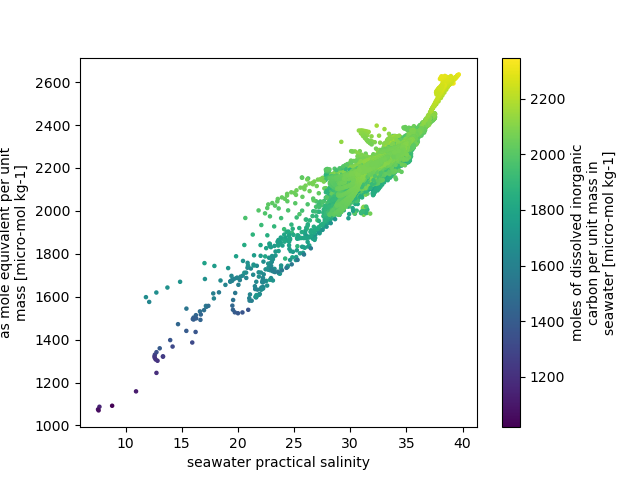

In [34]:
plt.figure()
surface.plot.scatter('salinity', 'alkalinity', s=5, hue='dic')

### PyCO2SYS calculations

Finally, to do a PyCO2SYS calculation, it's the same as before, but just remember that we need to add `.values` to each of the inputs:

<IPython.core.display.Javascript object>


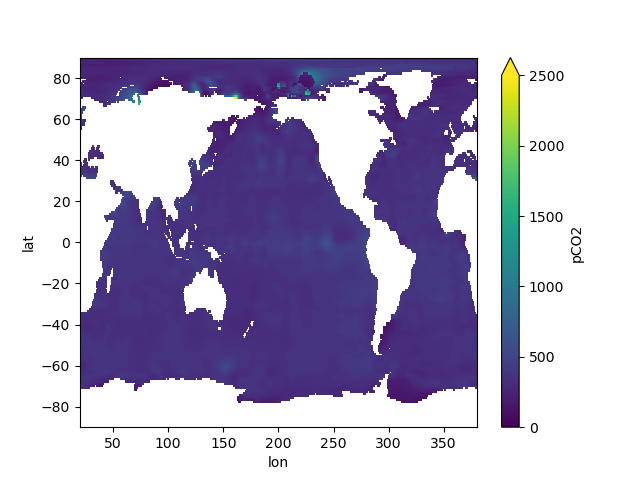

In [35]:
# Calculate initial surface ocean pCO2 with PyCO2SYS
results = pyco2.sys(
    surface.alkalinity.values, surface.dic.values, 1, 2,
    temperature=surface.temperature.values,
    salinity=surface.salinity.values,
)

# Recipe to add a new variable into the surface Dataset
surface['pCO2'] = (surface.dims, results['pCO2'])

# Plot the new variable
plt.figure()
surface.pCO2.plot(vmin=0, vmax=2500)  # adjust vmin and vmax to see more detail in the colours

## Geoengineering options

Several ways to encourage the ocean to take up more CO₂ from the ocean have been discussed.

**Iron fertilisation** has been suggested for high-nutrient, low-chlorophyll regions like the Southern Ocean.  Here, major nutrients (e.g. nitrate) are abundant because biological productivity is instead limited by the trace nutrient iron.  Adding iron in these regions might allow the nitrate to be all used up by new primary production, converting DIC into organic matter in the process.

**Ocean alkalinisation** or **liming** involves dissolving minerals like CaCO₃ or olivine into seawater.  These minerals increase alkalinity and thus enhance seawater's CO₂ storage capacity.  This method could be applied anywhere over the surface ocean.

### Questions

  1. How much nitrate is there in the surface mixed layer of the ocean?  Assume that the values in `surface` (in μmol/kg) are uniform down to the mixed layer depth.
  
  2. If this nitrate was all converted into organic matter, how much DIC would be taken up?  Use a C:N ratio for organic matter of 117:16, following [Anderson & Sarmiento (1994)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/93GB03318).
  
  3. Consider the amount of DIC calculated in the previous question.  We might assume that the ocean could now take an equal amount of CO₂ up out of the atmosphere to return to equilibrium.  How does this compare to anthropogenic emissions?
  
  4. How true is the assumption in the previous question likely to be, and why?  What processes could lead to either less or more CO₂ being taken up that was calculated? 
    
  5. If we dissolve CaCO₃ uniformly through the surface mixed layer and and assume re-equilibration back to the original seawater *p*CO₂, how much CaCO₃ do we need to dissolve to take up the same amount of CO₂ as we estimated for the iron fertilisation method?  Put the amount into context that the average person on the street could grasp.
  
  6. What is the key theoretical problem with the plan to dissolve CaCO₃ in the surface ocean?  How might this be overcome?

In [ ]:
# Save the planet here...
